In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
import statsmodels.formula.api as smf
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
#!pip install mlxtend==0.19.0
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#!pip install pygam
from pygam import GAM, s, te
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline

In [3]:
airquality=pd.read_csv("C:/Users/arab/Downloads/airquality.csv")
airquality=airquality[['Ozone','Solar.R','Wind','Temp']]
airquality=airquality.dropna()
airquality.head()

,Ozone,Solar.R,Wind,Temp
0,41.0,190.0,7.4,67
1,36.0,118.0,8.0,72
2,12.0,149.0,12.6,74
3,18.0,313.0,11.5,62
6,23.0,299.0,8.6,65


In [4]:
airquality['TWcp']=airquality['Temp']*airquality['Wind']
airquality['TWrat']=airquality['Temp']/airquality['Wind']
airquality.head()

,Ozone,Solar.R,Wind,Temp,TWcp,TWrat
0,41.0,190.0,7.4,67,495.8,9.054054
1,36.0,118.0,8.0,72,576.0,9.000000
2,12.0,149.0,12.6,74,932.4,5.873016
3,18.0,313.0,11.5,62,713.0,5.391304
6,23.0,299.0,8.6,65,559.0,7.558140


In [5]:
X=airquality[['Solar.R','Temp', 'Wind','TWcp','TWrat']]
y=airquality[['Ozone']]
gam=GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X,y)

In [6]:
gam=GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X,y)
gam.gridsearch(X=X, y=y, lam=np.linspace(0, 10, 100), return_scores=True)
gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     23.7254
Link Function:                     IdentityLink Log Likelihood:                                  -689.8064
Number of Samples:                          111 AIC:                                             1429.0636
                                                AICc:                                            1443.9817
                                                GCV:                                              318.7047
                                                Scale:                                            199.0505
                                                Pseudo R-Squared:                                   0.8574
Feature Function                  Lam

C:\Users\arab\AppData\Local\Temp/ipykernel_1304/1364313868.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [9]:
CV10 = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2928893)
airquality['CV'] = np.random.randint(low=0, high=10, size=(airquality.shape[0],))
airquality.head()

,Ozone,Solar.R,Wind,Temp,TWcp,TWrat,CV
0,41.0,190.0,7.4,67,495.8,9.054054,5
1,36.0,118.0,8.0,72,576.0,9.000000,9
2,12.0,149.0,12.6,74,932.4,5.873016,9
3,18.0,313.0,11.5,62,713.0,5.391304,2
6,23.0,299.0,8.6,65,559.0,7.558140,8


In [14]:
random_state=2928893
LS_MSPE=[]
Stepwize_MSPE= []
Ridge_MSPE = []
LASSO_MSPE = []
GAM_MSPE = []

for i in range(10):
    airquality_train = airquality.loc[airquality['CV'] != i]
    airquality_test = airquality.loc[airquality['CV'] == i]

    y_train = airquality_train['Ozone']
    X_train = airquality_train.drop(['Ozone','CV'],axis=1)
    y_test = airquality_test['Ozone']
    X_test = airquality_test.drop(['Ozone','CV'],axis=1)
   
    StdScaler = StandardScaler().fit(X_train)
    X_train_std = StdScaler.transform(X_train)
    X_test_std = StdScaler.transform(X_test)
 
  #LS
    MLReg = LinearRegression()
    MLReg.fit(X_train,y_train)
    LS_MSPE.append(mean_squared_error(y_test, MLReg.predict(X_test)))  
    
  # stepwise
    MLReg = LinearRegression()
    sfs4 = sfs(MLReg, k_features=5, floating=True, verbose=0, scoring='neg_mean_squared_error')
    sfs4.fit(X_train,y_train)
    X_train_sfs4 = sfs4.transform(X_train)
    X_test_sfs4 = sfs4.transform(X_test)
    MLReg.fit(X_train_sfs4, y_train)
    Stepwize_MSPE.append(mean_squared_error(y_test, MLReg.predict(X_test_sfs4)))

  # Ridge
    LMRidgeCV = RidgeCV(alphas=np.arange(0.5, 10, 0.01), cv=CV10, scoring='neg_mean_squared_error')
    LMRidgeCV.fit(X_train_std, y_train)
    LMRidge = Ridge(alpha = LMRidgeCV.alpha_)
    LMRidge.fit(X_train_std, y_train)
    Ridge_MSPE.append(mean_squared_error(y_test, LMRidge.predict(X_test_std)))

  # LASSO
    LMLassoCV = LassoCV(alphas = np.arange(0.5, 2, 0.01), cv = CV10)
    LMLassoCV.fit(X_train_std, y_train)
    LMLasso = Lasso()
    LMLasso.set_params(alpha=LMLassoCV.alpha_)
    LMLasso.fit(X_train_std, y_train)
    LASSO_MSPE.append(mean_squared_error(y_test, LMLasso.predict(X_test_std)))
    
  # GAM
    gam = GAM(s(0)+s(1)+s(2)+s(3)+s(4)).fit(X_train, y_train)
    gam.gridsearch(X=X_train, y=y_train, lam=np.linspace(3, 5, 20))
    GAM_MSPE.append(mean_squared_error(y_test, gam.predict(X_test)))

print(LS_MSPE)
print(Stepwize_MSPE)
print(Ridge_MSPE)
print(LASSO_MSPE)
print(GAM_MSPE)

100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


[327.7391679796945, 2625.34922524561, 313.2418246988366, 334.318076166133, 536.3228864387787, 207.90133435341957, 1087.015659956237, 344.70756143118274, 170.84748617998437, 269.07276351410195]
[327.7391679796945, 2625.34922524561, 313.2418246988366, 334.318076166133, 536.3228864387787, 207.90133435341957, 1087.015659956237, 344.70756143118274, 170.84748617998437, 269.07276351410195]
[380.09787935513316, 2203.688114799476, 369.55928001478514, 324.878197113733, 578.0310550351605, 193.59133954669142, 997.3674617552582, 334.2546014705165, 173.19124202608583, 293.9977348343407]
[360.21861346179503, 2136.4095136905157, 386.2926436254579, 345.90848804753546, 595.7984996521466, 182.8945103986827, 944.7914040633253, 345.10001242132967, 159.8699699330855, 308.1689535152094]
[136.55574130688493, 7408.477418791793, 208.79694800489565, 312.06268572119365, 466.7618607271437, 103.07560998713615, 501.6286674207101, 265.30896323552065, 142.52854164126214, 265.70675759956606]


   id Model         MSPE
0   0    LS   327.739168
1   1    LS  2625.349225
2   2    LS   313.241825
3   3    LS   334.318076
4   4    LS   536.322886


<AxesSubplot:xlabel='Model', ylabel='MSPE'>

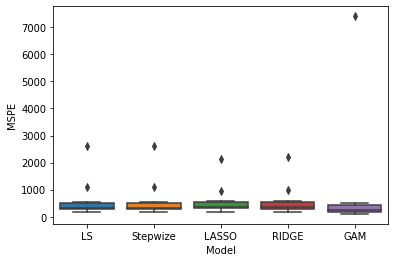

In [12]:
MSPEs=pd.DataFrame({'LS':LS_MSPE,
                    'Stepwize':Stepwize_MSPE,
                    'LASSO':LASSO_MSPE,
                    'RIDGE':Ridge_MSPE,
                    'GAM':GAM_MSPE})
MSPEs["id"] = MSPEs.index
MSPEs_long = pd.melt(MSPEs, id_vars='id',
                     var_name = 'Model',
                     value_name = 'MSPE',
                     value_vars=['LS','Stepwize','LASSO','RIDGE','GAM'])
print(MSPEs_long.head())
sns.boxplot(y="MSPE", x="Model", orient="v", data=MSPEs_long)

<AxesSubplot:xlabel='Model', ylabel='RMSPE'>

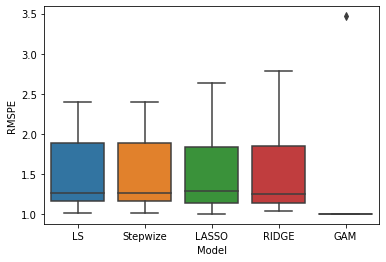

In [13]:
MSPEs = MSPEs.drop('id', axis=1)
RMSPEs = MSPEs.div(MSPEs.min(axis=1), axis=0)
RMSPEs["id"] = RMSPEs.index
RMSPEs_long = pd.melt(RMSPEs, id_vars='id',
                     var_name = 'Model',
                     value_name = 'RMSPE',
                     value_vars=['LS','Stepwize','LASSO','RIDGE','GAM'])
sns.boxplot(y="RMSPE", x="Model", orient="v", data=RMSPEs_long)